# Problem Statement

The problem at hand is **AI vs. Human Text Classification**. In today’s world, AI-generated content is present across almost every platform. While AI can refine and enhance text to a remarkable degree, there are spaces where we aim to evaluate the creativity, depth, and coherence of the human mind. In such contexts, it becomes essential to distinguish between AI-generated text and human-written content.

In this notebook, we will explore this problem in detail and work towards developing an effective solution for identifying the origin of a given piece of writing.

## About the Dataset

This dataset contains **487,235 essays** compiled from various sources, containing both **AI-generated and human-written** content. It includes the following two columns:

**text** – The raw text of the essay.

**generated** – The label indicating the source of the essay: 1.0 for AI-generated and 0.0 for human-written.


### Importing Necessary Libraries and Reading the Data

In [1]:
# Core Data Processing and Visualization Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
import re
import string
from collections import Counter
from IPython.display import display

# NLTK Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

# Utilities
from tqdm import tqdm
from joblib import Parallel, delayed
import joblib

# ML libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# For sparse matrix handling
from scipy.sparse import hstack, csr_matrix

In [ ]:
# Download required NLTK datasets and models
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [3]:
# Load the data
df = pd.read_csv('/kaggle/input/ai-vs-human-text/AI_Human.csv')
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


# Pre-Processing

In this section, we perform essential **preprocessing** steps required for any NLP problem. These include calculating message length, counting characters, words, and sentences, removing stopwords, lemmatizing, and more. The main goal is to **clean the text** and **generate features** that can be useful for both **analysis** and **model training**.

**Features Created**

**cleaned_text**: Tokenized, stopword-removed, lemmatized, and lowercased text, ready for input to models.

**msg_length**: Total character count of the entire essay.

**punct_count**: Total count of punctuation marks used.

**punctuation_density**: Number of punctuation marks per character.

**avg_word_length**: Average length of all words in the essay.

**sentence_count**: Total number of sentences in the essay.

**avg_sentence_length**: Average number of words per sentence.

**Notes**

Since these features are created using **NLTK tokenizers**, they provide more accurate tokenization by ignoring **punctuation tokens** like **commas (,)** and **semicolons (;)**, and correctly identifying **sentence boundaries** marked by **(.)**, **(!)**, and **(?)**.

In [14]:
# Load stopwords and Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_text_row(text):
    # Original stats (no cleaning)
    msg_length = len(text)
    punct_count = sum(1 for char in text if char in string.punctuation)
    punct_density = punct_count / msg_length if msg_length > 0 else 0

    # Tokenize
    words = [w for w in word_tokenize(text) if w not in string.punctuation]
    avg_word_length = sum(len(w) for w in words) / len(words) if words else 0

    sentences = sent_tokenize(text)
    sentence_count = len(sentences)
    avg_sentence_length = len(words) / sentence_count if sentence_count > 0 else 0

    # Clean text
    clean_tokens = [
        lemmatizer.lemmatize(w.lower()) 
        for w in words 
        if w.lower() not in stop_words
    ]
    cleaned_text = " ".join(clean_tokens)

    return {
        "cleaned_text": cleaned_text,
        "msg_length": msg_length,
        "punct_count": punct_count,
        "punctuation_density": punct_density,
        "avg_word_length": avg_word_length,
        "sentence_count": sentence_count,
        "avg_sentence_length": avg_sentence_length
    }

# Parallel processing with tqdm progress bar
results = Parallel(n_jobs=-1)(
    delayed(process_text_row)(txt) 
    for txt in tqdm(df['text'], desc="Processing texts", unit="doc")
)

# Merge into DataFrame
features_df = pd.DataFrame(results)
df = pd.concat([df, features_df], axis=1)

df

,text,generated,cleaned_text,msg_length,punct_count,punctuation_density,avg_word_length,sentence_count,avg_sentence_length
0,Cars. Cars have been around since they became ...,0.0,car car around since became famous 1900s henry...,3289,75,0.022803,4.447059,23,25.869565
1,Transportation is a large necessity in most co...,0.0,transportation large necessity country worldwi...,2738,64,0.023375,4.745182,27,17.296296
2,"""America's love affair with it's vehicles seem...",0.0,`` america 's love affair 's vehicle seems coo...,4428,101,0.022809,4.732026,48,15.937500
3,How often do you ride in a car? Do you drive a...,0.0,often ride car drive one motor vehicle work st...,4013,124,0.030900,4.534075,47,15.297872
4,Cars are a wonderful thing. They are perhaps o...,0.0,car wonderful thing perhaps one world greatest...,4698,110,0.023414,4.243792,50,17.720000
...,...,...,...,...,...,...,...,...,...
487230,Tie Face on Mars is really just a big misunder...,0.0,tie face mar really big misunderstanding stron...,968,16,0.016529,3.912371,12,16.166667
487231,The whole purpose of democracy is to create a ...,0.0,whole purpose democracy create government refl...,2319,46,0.019836,4.856777,14,27.928571
487232,I firmly believe that governments worldwide sh...,1.0,firmly believe government worldwide take immed...,2392,58,0.024247,5.447514,16,22.625000
487233,I DFN't agree with this decision because a LFT...,0.0,dfn't agree decision lft ff kid may nft want t...,1668,24,0.014388,3.833333,13,26.307692


The texts have been processed and will be saved so that they can be used later directly, instead of conducting the entire preprocesing step all over again.

In [4]:
# Save Processed Text
df.to_parquet("Processed_Texts.parquet", engine="pyarrow", index=False)

In [5]:
# Save Processed Text to ZIP File
!zip -r /kaggle/working/Processed_Texts.zip /kaggle/working/Processed_Texts.parquet

  adding: kaggle/working/Processed_Texts.parquet (deflated 11%)


# Feature Analysis on Proceccesed Data

## Data Distribution

We'll start with a **simple graph** to examine the **label distribution** in the dataset. This helps us understand if there is any **imbalance** between the classes.

The graph below shows the count of essays that are **human-written** versus those that are **AI-generated**.

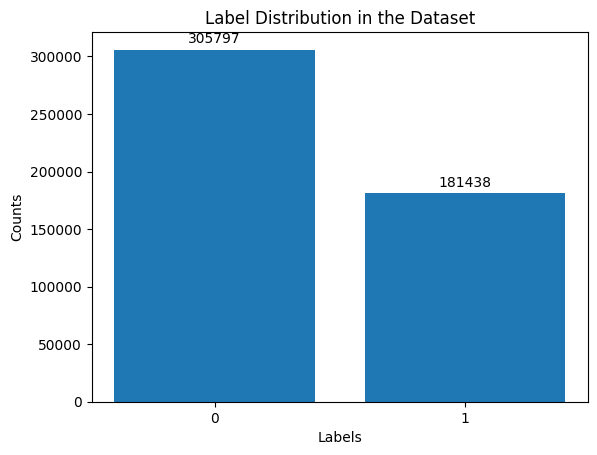

In [5]:
# Plot label distribution
count_list = df["generated"].value_counts()
labels = ["0", "1"]
counts = [count_list[0], count_list[1]]

plt.bar(labels, counts)
plt.title('Label Distribution in the Dataset')
plt.xlabel('Labels')
plt.ylabel('Counts')

for i, count in enumerate(counts):
    plt.text(i, count + max(counts)*0.01, str(count), ha='center', va='bottom')

plt.show()


From the distribution, we observe that the **Human : AI** ratio is approximately **305,797 : 181,438**.
This indicates that the dataset is slightly imbalanced towards human-written text, which constitutes approximately **63%** of the data. However, this is not a significant concern since it reflects **real-world** scenarios where most available text is human-generated.

Additionally, although AI-generated text is less than human text, **the number of AI samples is still substantial**. Therefore, there is no immediate need for upsampling or downsampling to address this imbalance, and we can confidently proceed with the dataset as is.

## Word Clouds

A **Word Cloud** is a **visual representation** of the **most frequently used words** in the text, where word **size reflects their frequency**. It helps us gain insights into the **vocabulary** and **common themes** within the data.

In this section, we will create **separate word clouds for Human-written and AI-generated texts** to explore the distinct vocabularies used by each and see if we can draw any meaningful conclusions.

In [3]:
df = pd.read_csv('/kaggle/input/ai-vs-human-text/AI_Human.csv')

In [6]:
# Separate Human and AI Data
human_data = df[df["generated"]==0]
ai_data = df[df["generated"]==1]
human_text=list(human_data["text"])
ai_text=list(ai_data["text"])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


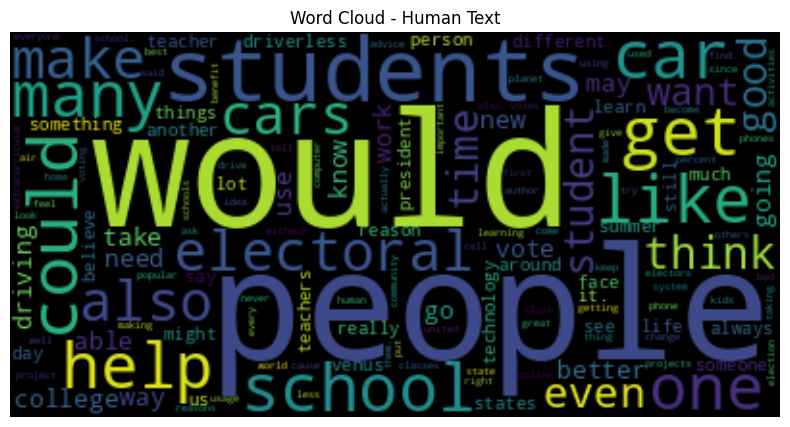

In [7]:
# Plot Human Text Word Cloud
stop_words = set(stopwords.words('english'))

combined_human_text = ' '.join(human_text)
combined_human_text = combined_human_text.lower() 
human_tokens = combined_human_text.split()
human_filtered_tokens = [word for word in human_tokens if word not in stop_words]

human_word_freq = Counter(human_filtered_tokens) 

human_wordcloud = WordCloud().generate_from_frequencies(human_word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(human_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Human Text")
plt.show()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


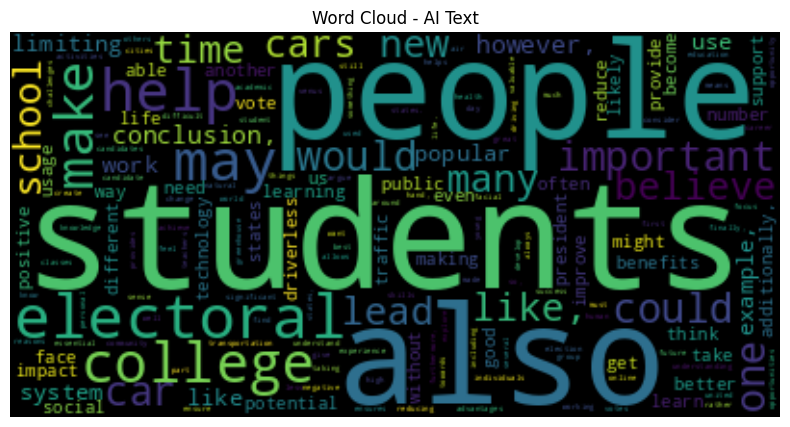

In [8]:
# Plot AI Text Word Cloud
stop_words = set(stopwords.words('english'))

combined_ai_text = ' '.join(ai_text)
combined_ai_text = combined_ai_text.lower() 
ai_tokens = combined_ai_text.split()
ai_filtered_tokens = [word for word in ai_tokens if word not in stop_words]

ai_word_freq = Counter(ai_filtered_tokens)

ai_wordcloud = WordCloud().generate_from_frequencies(ai_word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(ai_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - AI Text")
plt.show()

## Syntactic and Structural Feature Analysis

Now, we will use the features created during the preprocessing steps. First, we will load the preprocessed data and then provide a **statistical summary** of each engineered feature, including the **mean, median, and standard deviation**.

Additionally, these summaries will be broken down **by label**, allowing us to understand how the **features differ** between **human-written** and **AI-generated text**.

In [4]:
# Load Processed Data
df = pd.read_parquet('/kaggle/input/processedessays/Processed_Texts/kaggle/working/Processed_Texts.parquet')
df.head()

,text,generated,cleaned_text,msg_length,punct_count,punctuation_density,avg_word_length,sentence_count,avg_sentence_length
0,Cars. Cars have been around since they became ...,0.0,car car around since became famous 1900s henry...,3289,75,0.022803,4.447059,23,25.869565
1,Transportation is a large necessity in most co...,0.0,transportation large necessity country worldwi...,2738,64,0.023375,4.745182,27,17.296296
2,"""America's love affair with it's vehicles seem...",0.0,`` america 's love affair 's vehicle seems coo...,4428,101,0.022809,4.732026,48,15.937500
3,How often do you ride in a car? Do you drive a...,0.0,often ride car drive one motor vehicle work st...,4013,124,0.030900,4.534075,47,15.297872
4,Cars are a wonderful thing. They are perhaps o...,0.0,car wonderful thing perhaps one world greatest...,4698,110,0.023414,4.243792,50,17.720000


In [11]:
# Stats to be calculated
stats_to_show = ["mean", "50%", "std"]

# Feature columns
feature_cols = [
    "avg_word_length",
    "sentence_count",
    "avg_sentence_length",
    "punctuation_density",
    "msg_length",
    "punct_count"
]

# Group descriptive stats & flatten columns
desc = df.groupby("generated")[feature_cols].describe().round(4)
desc.columns = ['_'.join(col) for col in desc.columns]  # Flatten MultiIndex

# Build comparison DataFrame
comparison = {}
for feature in feature_cols:
    comparison[feature] = {}
    for stat in stats_to_show:
        comparison[feature][f"Label 0 ({stat})"] = desc.loc[0, f"{feature}_{stat}"]
        comparison[feature][f"Label 1 ({stat})"] = desc.loc[1, f"{feature}_{stat}"]

comp_df = pd.DataFrame(comparison).T

display(comp_df.style.format(precision=4))

,Label 0 (mean),Label 1 (mean),Label 0 (50%),Label 1 (50%),Label 0 (std),Label 1 (std)
avg_word_length,4.3649,4.9494,4.3580,4.9527,0.3051,0.5808
sentence_count,21.2707,18.4979,20.0000,18.0000,9.8756,6.6983
avg_sentence_length,22.3032,19.4891,20.0000,19.3333,15.6592,4.0199
punctuation_density,0.0208,0.0221,0.0202,0.0199,0.0063,0.0090
msg_length,2354.5928,2126.3164,2156.0000,2048.0000,1082.0131,787.2549
punct_count,48.9961,46.5521,44.0000,42.0000,27.2416,22.4286


**Key Findings:**

**Average Word Length** - The average word length per essay is **4.36** for human-written text and **4.95** for AI-generated text. The standard deviation is **0.31** for human text and **0.58** for AI text. While these differences are modest, they suggest that AI tends to use slightly **longer words** on average—possibly to refine meaning. Common shorter words like articles, pronouns, and prepositions are consistently used by both, which keeps human text more uniform and results in a lower standard deviation compared to AI-generated text.

**Average Sentence Count** - Human-written essays contain an average of **21.27** sentences, compared to **18.50** for AI-generated essays. The standard deviation is higher for humans at **9.88** versus **6.70** for AI. This indicates that human writing exhibits more **variability and inconsistency** in the number of sentences.

**Average Sentence Length** - The average sentence length is **22.30** words for human text and **19.5** words for AI text. The difference in standard deviation is substantial: **15.66** for human text versus **4.02** for AI. This further supports the observation that human text tends to be more **diverse and variable** in sentence structure.

**Punctuation Count and Density** - For punctuation count, the standard deviation is **27.24** for human text and **22.43** for AI text. For punctuation density, the values are **0.0063** for humans and **0.0090** for AI. Although these differences are less pronounced, they indicate that AI-generated text tends to be more **variable in punctuation** usage, which is a notable feature since punctuation can reflect stylistic patterns.

**Message Length** - The average character length per essay is **2,354.59** for human text and **2,126.32** for AI text. Standard deviation values are **1,082.01** for human text and **787.25** for AI text. This again emphasizes that human-written essays tend to be **longer and more variable** in length.

Below are **several graphs** illustrating the **distribution** of each feature along with the differences in their **standard deviations**. These visualizations help to clearly demonstrate the **distinctions** discussed above.

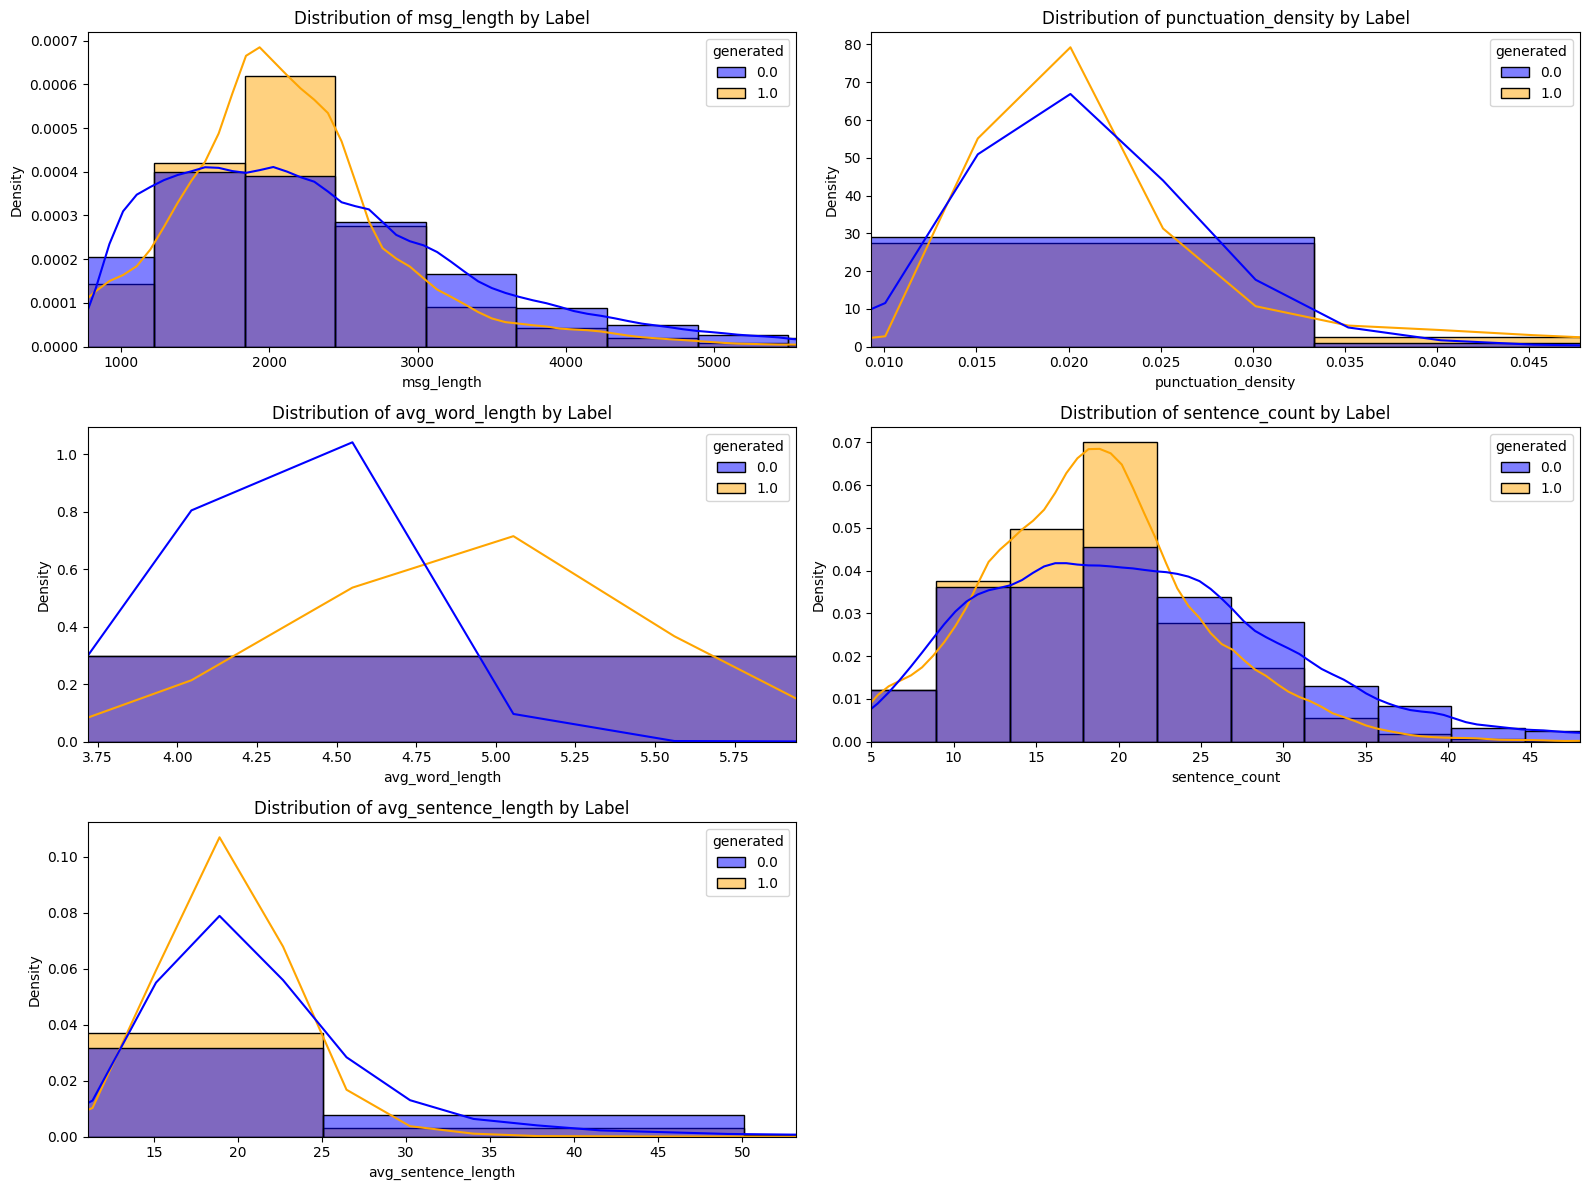

In [38]:
# Features to Plot
features_to_plot = [
    "msg_length",
    "punctuation_density",
    "avg_word_length",
    "sentence_count",
    "avg_sentence_length"
]

plt.figure(figsize=(16, 12))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 2, i)
    
    # Calculate 1st and 99th percentile limits for this feature
    lower = np.percentile(df[feature], 1)
    upper = np.percentile(df[feature], 99)
    
    sns.histplot(
        data=df,
        x=feature,
        hue='generated',
        bins=30,
        kde=True,
        stat="density",
        common_norm=False,
        palette=['blue', 'orange']
    )
    
    plt.title(f'Distribution of {feature} by Label')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.xlim(lower, upper)

plt.tight_layout()
plt.show()

This **first set of graphs** shows the **distribution of each feature** for **human-written and AI-generated texts**, highlighting how the values vary between the two groups.

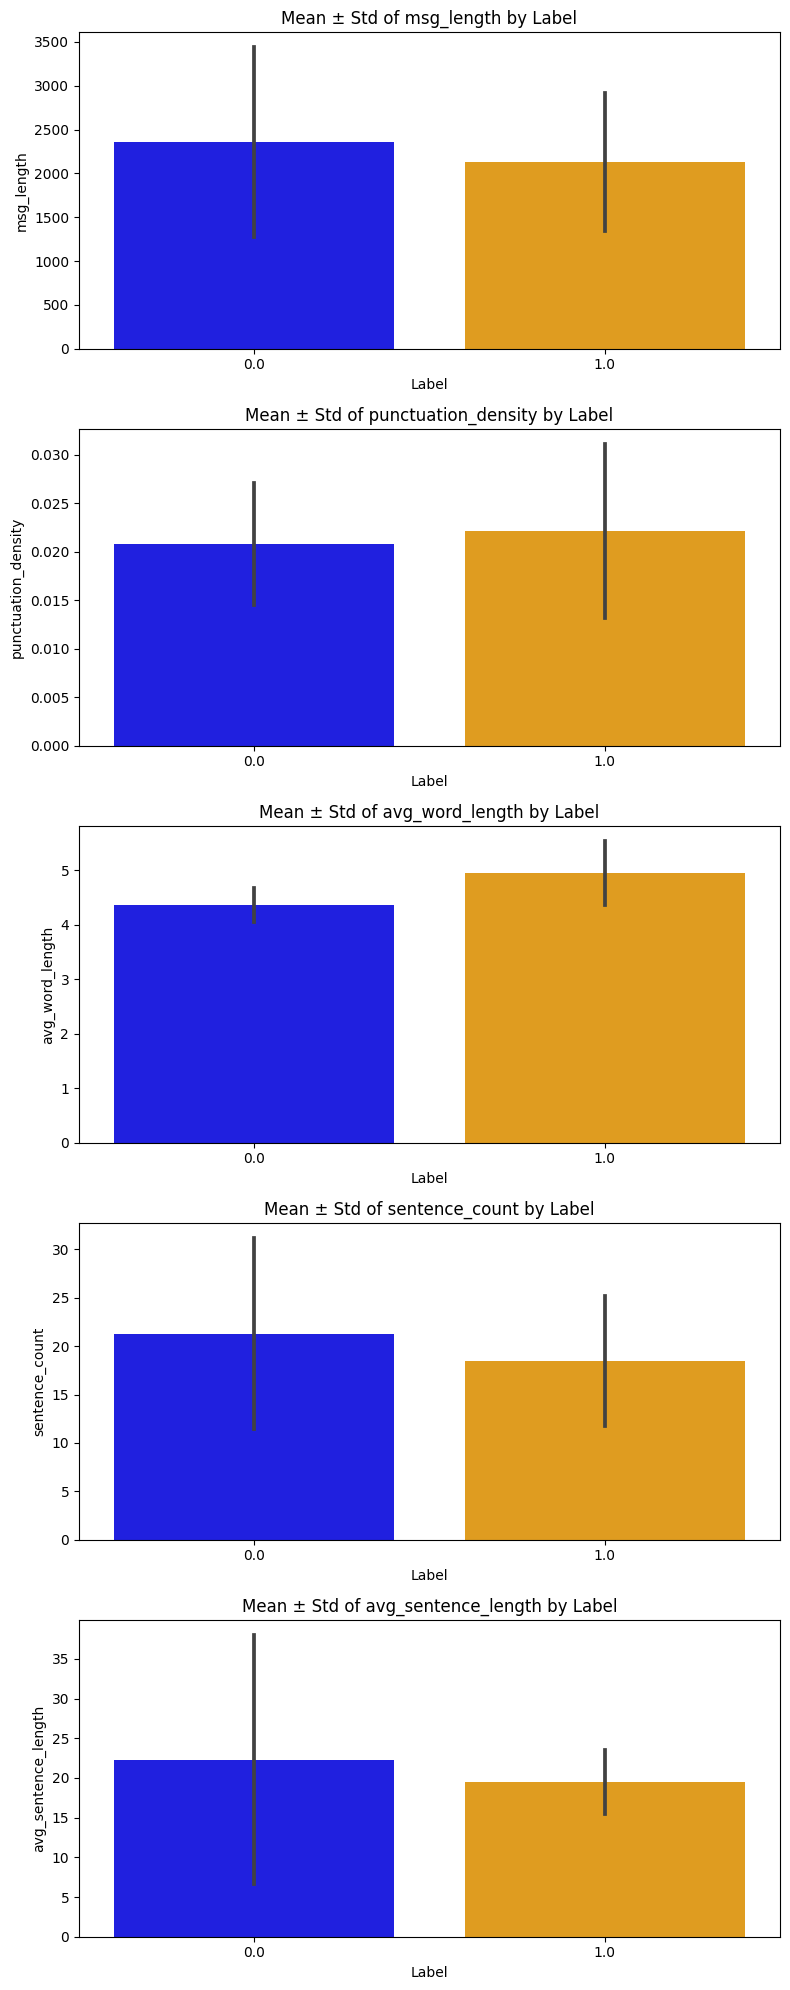

In [47]:
# Features to Plot
features_to_plot = [
    "msg_length",
    "punctuation_density",
    "avg_word_length",
    "sentence_count",
    "avg_sentence_length"
]

melted = df.melt(id_vars='generated', value_vars=features_to_plot,
                      var_name='feature', value_name='value')

num_features = len(features_to_plot)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, 4 * num_features))

for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    sns.barplot(
        data=melted[melted['feature'] == feature],
        x='generated', y='value', ci='sd', ax=ax, palette=['blue', 'orange']
    )
    ax.set_title(f'Mean ± Std of {feature} by Label')
    ax.set_xlabel('Label')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()

This **second set of graphs** focuses on the **differences in standard deviation** for these features, **emphasizing the variability and consistency** within each class.

# Model Set Up and Training

**Model Training Plan:**

We will categorize the features into two types:

1. **Clean Text**
2. **Numerical Features**

Using these, we will conduct three types of training experiments:

1. Training with **only numerical features**
2. Training with **only clean text**
3. Training with **both clean text and numerical features**

For modeling, we will use two algorithms:

1. **Logistic Regression** as the lightweight baseline model
2. **Random Forest Classifier** as a more powerful model

In [15]:
# ====== Define features ======
text_col = "cleaned_text"
numeric_features = [
    "msg_length", "punctuation_density", "avg_word_length",
    "sentence_count", "avg_sentence_length"
]

X_text = df[text_col]
X_feats = df[numeric_features]
y = df['generated']

# ====== Split data ======
X_text_train, X_text_test, X_feats_train, X_feats_test, y_train, y_test = train_test_split(
    X_text, X_feats, y, test_size=0.2, random_state=42, stratify=y
)

In [16]:
def train_and_evaluate(X_train, X_test, y_train, y_test, suffix):
    """
    Trains Logistic Regression and Random Forest on given X/y datasets,
    shows classification report, and confusion matrix.
    """
    for model_name, model in [
        ("LogisticRegression", LogisticRegression(max_iter=1000)),
        ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42))
    ]:
        print(f"\nTraining {model_name} ({suffix})...")

        with tqdm(total=1, desc=f"Fitting {model_name} ({suffix})") as pbar:
            model.fit(X_train, y_train)
            pbar.update(1)

        # Save model
        filename = f"{model_name}_{suffix}.joblib"
        joblib.dump(model, filename)
        print(f"Saved model to {filename}")

        # Predictions
        preds = model.predict(X_test)

        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_test, preds))

        # Confusion matrix
        cm = confusion_matrix(y_test, preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix - {model_name} ({suffix})")
        plt.show()


## 1. Numeric features only


Training LogisticRegression (FeatsOnly)...



Fitting LogisticRegression (FeatsOnly): 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


Saved model to LogisticRegression_FeatsOnly.joblib

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85     61159
         1.0       0.76      0.68      0.72     36288

    accuracy                           0.80     97447
   macro avg       0.79      0.77      0.78     97447
weighted avg       0.80      0.80      0.80     97447



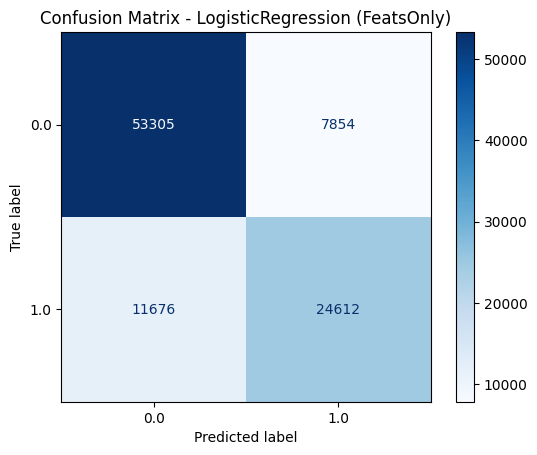


Training RandomForest (FeatsOnly)...



Fitting RandomForest (FeatsOnly): 100%|██████████| 1/1 [02:03<00:00, 123.76s/it]


Saved model to RandomForest_FeatsOnly.joblib

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     61159
         1.0       0.97      0.95      0.96     36288

    accuracy                           0.97     97447
   macro avg       0.97      0.97      0.97     97447
weighted avg       0.97      0.97      0.97     97447



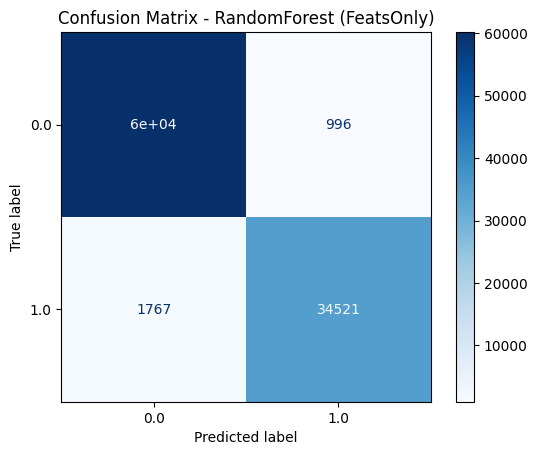

In [60]:
train_and_evaluate(X_feats_train, X_feats_test, y_train, y_test, "FeatsOnly")

## 2. Clean text only (TF-IDF)


Training LogisticRegression (TextOnly)...


Fitting LogisticRegression (TextOnly): 100%|██████████| 1/1 [00:22<00:00, 22.23s/it]


Saved model to LogisticRegression_TextOnly.joblib

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     61159
         1.0       0.98      0.98      0.98     36288

    accuracy                           0.99     97447
   macro avg       0.99      0.98      0.98     97447
weighted avg       0.99      0.99      0.99     97447



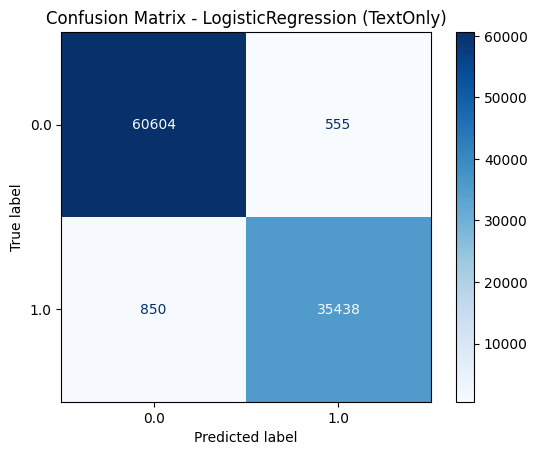


Training RandomForest (TextOnly)...


Fitting RandomForest (TextOnly): 100%|██████████| 1/1 [42:37<00:00, 2557.97s/it]


Saved model to RandomForest_TextOnly.joblib

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     61159
         1.0       1.00      1.00      1.00     36288

    accuracy                           1.00     97447
   macro avg       1.00      1.00      1.00     97447
weighted avg       1.00      1.00      1.00     97447



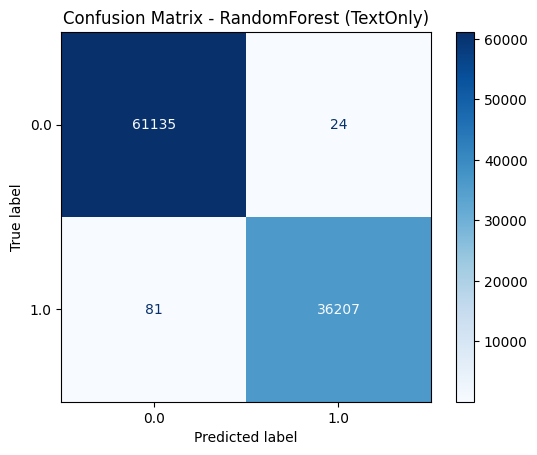

In [17]:
tfidf = TfidfVectorizer(max_features=1000)
X_train_text_tfidf = tfidf.fit_transform(X_text_train)
X_test_text_tfidf = tfidf.transform(X_text_test)
train_and_evaluate(X_train_text_tfidf, X_test_text_tfidf, y_train, y_test, "TextOnly")


## 3. Combined numeric features + text


Training LogisticRegression (TextPlusFeats)...



Fitting LogisticRegression (TextPlusFeats): 100%|██████████| 1/1 [02:50<00:00, 170.62s/it]


Saved model to LogisticRegression_TextPlusFeats.joblib

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     61159
         1.0       0.98      0.97      0.97     36288

    accuracy                           0.98     97447
   macro avg       0.98      0.98      0.98     97447
weighted avg       0.98      0.98      0.98     97447



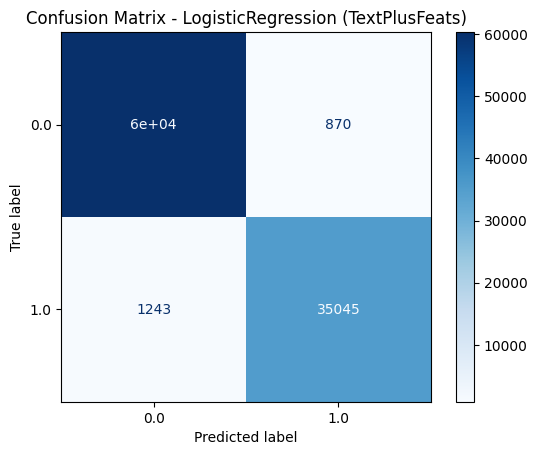


Training RandomForest (TextPlusFeats)...



Fitting RandomForest (TextPlusFeats): 100%|██████████| 1/1 [41:58<00:00, 2518.05s/it]


Saved model to RandomForest_TextPlusFeats.joblib

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     61159
         1.0       1.00      1.00      1.00     36288

    accuracy                           1.00     97447
   macro avg       1.00      1.00      1.00     97447
weighted avg       1.00      1.00      1.00     97447



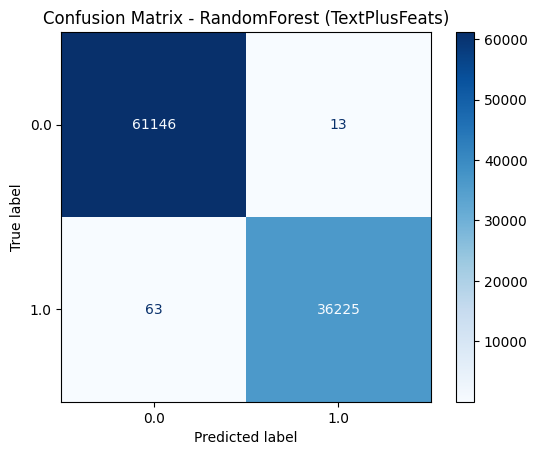

In [64]:
X_train_combined = hstack([X_train_text_tfidf, X_feats_train])
X_test_combined = hstack([X_test_text_tfidf, X_feats_test])

train_and_evaluate(X_train_combined, X_test_combined, y_train, y_test, "TextPlusFeats")

## Analysing Model Results

**By Model** - 

The **Random Forest Classifier** consistently outperforms the **Logistic Regression** model in all experiments, as expected from a more powerful and flexible algorithm. One notable observation is that when both text and numerical features are provided, Logistic Regression’s performance drops slightly. This may be due to overfitting caused by the large number of features. In contrast, the Random Forest model handles the additional features effectively, showing improved performance.

**By Input Features** - 

**Numerical Features Only** - In this experiment, only numerical features are used. Models train **extremely quickly** and make predictions at the same pace, making them **lightweight** and ideal for scenarios with computational constraints. Despite their simplicity, the results are strong enough to be considered for the classification task.

**Text Features Only** - This setup uses only cleaned text features, which requires **TF-IDF** transformation before training. Training takes **noticeably longer** compared to numerical features, but the results are **significantly better**, reflecting the value of contextual information extracted from the text. This configuration produces the **highest accuracy for Logistic Regression** among all experiments.

**Text + Numerical Features** - In this final experiment, both cleaned text and numerical features are combined. For Logistic Regression, training time increases sharply, yet performance drops slightly—likely due to increased complexity and mild overfitting. For Random Forest, training time increases only marginally while accuracy improves slightly. Whether this improvement justifies the added complexity depends on the use case. Nonetheless, this configuration achieves the **highest overall accuracy** across all experiments.

## Cross-Validation and Its Importance

**Cross-validation** is important to evaluate the **performance and generalizability** of a machine learning model. Instead of training and testing the model on a single split of the dataset—which can lead to **overfitting** or an overly optimistic evaluation—cross-validation splits the data into **multiple folds**. The model is trained on a combination of folds and tested on the remaining fold, repeating this process so that every data point is used for both training and validation.

In **Stratified K-Fold Cross-Validation** (here we go with **5 fold cross-validation**), we also preserve the **class distribution** in each fold, ensuring **fair and balanced** evaluation for classification problems. This process reduces the impact of random chance in the train/test split and provides a more robust estimate of how the model will perform on unseen data.

In [4]:
def folded_evaluation(model, X, y, exp ,n_splits=5):
    """
    Perform Stratified K-Fold cross-validation with fresh training each fold.
    
    Parameters:
        model_class: uninitialized model (e.g., RandomForestClassifier()).
        X, y: NumPy arrays or DataFrames.
        n_splits: number of folds.
    """
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    metrics_list = []
    conf_matrices = []

    text_col = "cleaned_text"
    numeric_features = [
    "msg_length", "punctuation_density", "avg_word_length",
    "sentence_count", "avg_sentence_length"
    ]
    
    if exp == 'FeatsOnly':
        X = X[numeric_features]
    elif exp == 'TextOnly':
        X = X[text_col]
    elif exp == 'TextPlusFeats':
        pass
    else:
        return

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), start=1):
        print(f"\nTraining and evaluating fold {fold}/{n_splits}...")

        # Split into train and validation
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Fresh model each fold
        # model = model_class.__class__(**model_class.get_params())
        if exp == 'TextOnly':
            tfidf = TfidfVectorizer(max_features=1000)
            X_train = tfidf.fit_transform(X_train)
            X_val = tfidf.transform(X_val)
        elif exp == 'TextPlusFeats':
            tfidf = TfidfVectorizer(max_features=1000)
            X_train_tfidf = tfidf.fit_transform(X_train[text_col])
            X_val_tfidf = tfidf.transform(X_val[text_col])
            X_train = hstack([X_train_tfidf, X_train[numeric_features]])
            X_val = hstack([X_val_tfidf, X_val[numeric_features]])
        
        model.fit(X_train, y_train)

        preds = model.predict(X_val)

        # Metrics
        acc = accuracy_score(y_val, preds)
        prec = precision_score(y_val, preds, average='weighted', zero_division=0)
        rec = recall_score(y_val, preds, average='weighted', zero_division=0)
        f1 = f1_score(y_val, preds, average='weighted', zero_division=0)

        metrics_list.append([fold, acc, prec, rec, f1])

        # Confusion matrix
        cm = confusion_matrix(y_val, preds)
        conf_matrices.append(cm)

    # Results table
    results_df = pd.DataFrame(metrics_list, columns=["Fold", "Accuracy", "Precision", "Recall", "F1"])
    print("\nPer-fold results:")
    print(results_df)

    print("\nAverage results across folds:")
    print(results_df.mean(numeric_only=True))

    # Average confusion matrix
    avg_cm = np.mean(conf_matrices, axis=0)
    plt.figure(figsize=(6, 5))
    sns.heatmap(avg_cm, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Average Confusion Matrix (across folds)")
    plt.show()

### Cross Validation on Logistic Regression - Only Numeric Features


Training and evaluating fold 1/5...

Training and evaluating fold 2/5...

Training and evaluating fold 3/5...

Training and evaluating fold 4/5...

Training and evaluating fold 5/5...

Per-fold results:
   Fold  Accuracy  Precision    Recall        F1
0     1  0.823986   0.822436  0.823986  0.821236
1     2  0.798588   0.796143  0.798588  0.796161
2     3  0.822745   0.821175  0.822745  0.819920
3     4  0.825187   0.823681  0.825187  0.822458
4     5  0.799604   0.797223  0.799604  0.797320

Average results across folds:
Fold         3.000000
Accuracy     0.814022
Precision    0.812132
Recall       0.814022
F1           0.811419
dtype: float64


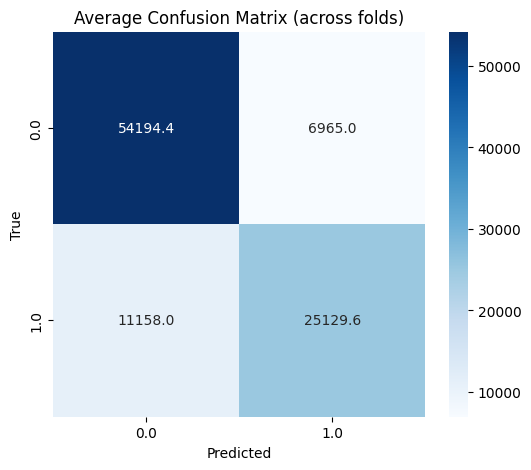

In [35]:
lr = LogisticRegression(max_iter=1000)
all_features = ["cleaned_text",
    "msg_length", "punctuation_density", "avg_word_length",
    "sentence_count", "avg_sentence_length"
]

X = df[all_features]
y = df['generated']
folded_evaluation(lr,X,y,'FeatsOnly')

### Cross Validation on Logistic Regression - Only Cleaned Text


Training and evaluating fold 1/5...

Training and evaluating fold 2/5...

Training and evaluating fold 3/5...

Training and evaluating fold 4/5...

Training and evaluating fold 5/5...

Per-fold results:
   Fold  Accuracy  Precision    Recall        F1
0     1  0.984843   0.984838  0.984843  0.984829
1     2  0.985428   0.985425  0.985428  0.985414
2     3  0.984658   0.984654  0.984658  0.984644
3     4  0.985387   0.985384  0.985387  0.985373
4     5  0.985346   0.985343  0.985346  0.985332

Average results across folds:
Fold         3.000000
Accuracy     0.985132
Precision    0.985129
Recall       0.985132
F1           0.985118
dtype: float64


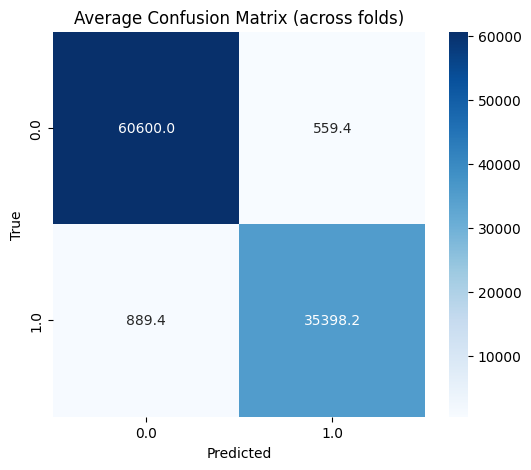

In [37]:
lr = LogisticRegression(max_iter=1000)
all_features = ["cleaned_text",
    "msg_length", "punctuation_density", "avg_word_length",
    "sentence_count", "avg_sentence_length"
]

X = df[all_features]
y = df['generated']
folded_evaluation(lr,X,y,'TextOnly')

### Cross Validation on Logistic Regression - Both Cleaned Text and Numeric Features


Training and evaluating fold 1/5...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Training and evaluating fold 2/5...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Training and evaluating fold 3/5...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Training and evaluating fold 4/5...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Training and evaluating fold 5/5...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Per-fold results:
   Fold  Accuracy  Precision    Recall        F1
0     1  0.974376   0.974352  0.974376  0.974348
1     2  0.976962   0.976944  0.976962  0.976936
2     3  0.979035   0.979019  0.979035  0.979018
3     4  0.979096   0.979083  0.979096  0.979073
4     5  0.977465   0.977446  0.977465  0.977443

Average results across folds:
Fold         3.000000
Accuracy     0.977387
Precision    0.977369
Recall       0.977387
F1           0.977364
dtype: float64


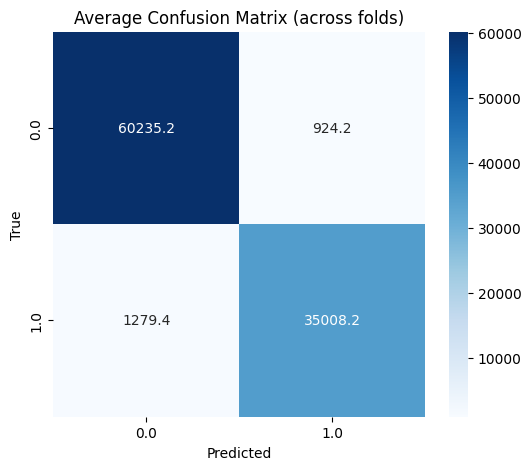

In [42]:
lr = LogisticRegression(max_iter=1000)
all_features = ["cleaned_text",
    "msg_length", "punctuation_density", "avg_word_length",
    "sentence_count", "avg_sentence_length"
]

X = df[all_features]
y = df['generated']
folded_evaluation(lr,X,y,'TextPlusFeats')

### Cross Validation on Random Forest - Only Numeric Features


Training and evaluating fold 1/5...

Training and evaluating fold 2/5...

Training and evaluating fold 3/5...

Training and evaluating fold 4/5...

Training and evaluating fold 5/5...

Per-fold results:
   Fold  Accuracy  Precision    Recall        F1
0     1  0.971195   0.971199  0.971195  0.971129
1     2  0.970661   0.970690  0.970661  0.970582
2     3  0.970661   0.970678  0.970661  0.970587
3     4  0.972323   0.972331  0.972323  0.972261
4     5  0.971841   0.971853  0.971841  0.971775

Average results across folds:
Fold         3.000000
Accuracy     0.971336
Precision    0.971350
Recall       0.971336
F1           0.971267
dtype: float64


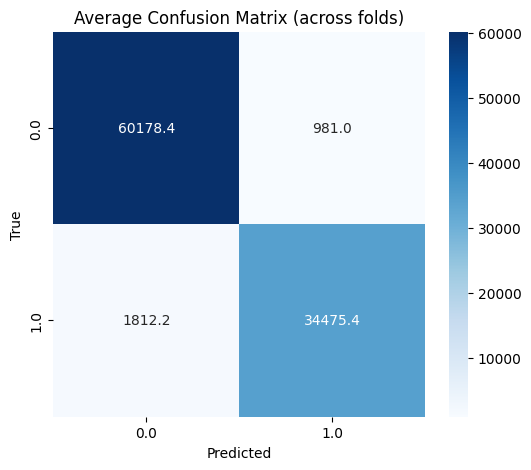

In [43]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
all_features = ["cleaned_text",
    "msg_length", "punctuation_density", "avg_word_length",
    "sentence_count", "avg_sentence_length"
]

X = df[all_features]
y = df['generated']
folded_evaluation(rfc,X,y,'FeatsOnly')

### Cross Validation on Random Forest - Only Cleaned Text


Training and evaluating fold 1/5...

Training and evaluating fold 2/5...

Training and evaluating fold 3/5...

Training and evaluating fold 4/5...

Training and evaluating fold 5/5...

Per-fold results:
   Fold  Accuracy  Precision    Recall        F1
0     1  0.998861   0.998861  0.998861  0.998861
1     2  0.999087   0.999087  0.999087  0.999087
2     3  0.999169   0.999169  0.999169  0.999169
3     4  0.999087   0.999087  0.999087  0.999087
4     5  0.999097   0.999097  0.999097  0.999097

Average results across folds:
Fold         3.00000
Accuracy     0.99906
Precision    0.99906
Recall       0.99906
F1           0.99906
dtype: float64


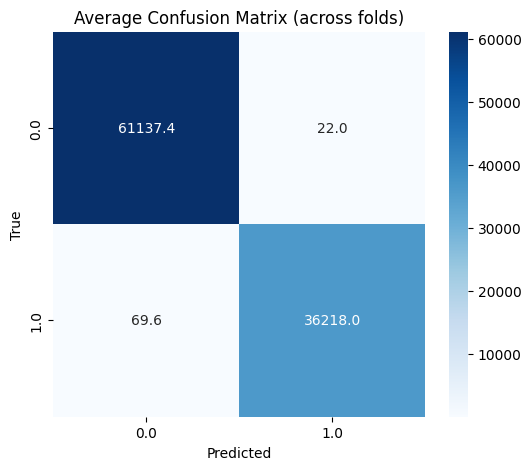

In [54]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
all_features = ["cleaned_text",
    "msg_length", "punctuation_density", "avg_word_length",
    "sentence_count", "avg_sentence_length"
]

X = df[all_features]
y = df['generated']
folded_evaluation(rfc,X,y,'TextOnly')

### Cross Validation on Random Forest - Both Cleaned Text and Numeric Features


Training and evaluating fold 1/5...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 18.4min
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 37.3min finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.2s finished



Training and evaluating fold 2/5...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 19.1min
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 38.9min finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.2s finished



Training and evaluating fold 3/5...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 19.6min
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 39.9min finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.2s finished



Training and evaluating fold 4/5...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 19.8min
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 40.0min finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.2s finished



Training and evaluating fold 5/5...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 19.8min
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 40.1min finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.2s finished



Per-fold results:
   Fold  Accuracy  Precision    Recall        F1
0     1  0.999035   0.999036  0.999035  0.999035
1     2  0.999169   0.999169  0.999169  0.999169
2     3  0.999384   0.999385  0.999384  0.999384
3     4  0.999353   0.999354  0.999353  0.999353
4     5  0.999271   0.999271  0.999271  0.999271

Average results across folds:
Fold         3.000000
Accuracy     0.999243
Precision    0.999243
Recall       0.999243
F1           0.999243
dtype: float64


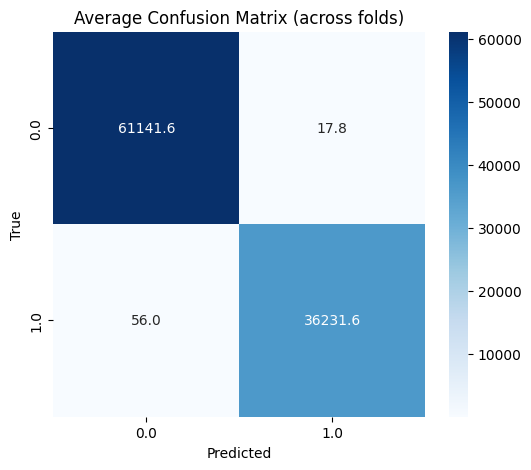

In [5]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)
all_features = ["cleaned_text",
    "msg_length", "punctuation_density", "avg_word_length",
    "sentence_count", "avg_sentence_length"
]

X = df[all_features]
y = df['generated']
folded_evaluation(rfc,X,y,'TextPlusFeats')

## Analysis of Cross-Validation Results

After conducting **5-fold cross-validation**, we observed that the key performance metrics—**accuracy, precision, recall, and F1-score**—remained **relatively consistent across all folds**. The variation between folds was minimal, indicating that the model’s performance is **stable** and **not overly dependent on a specific subset** of the training data.
This consistency suggests that the model is **generalizing well** to new, unseen data rather than simply memorizing patterns from a specific portion of the dataset. As a result, the cross-validation results give us confidence that the model’s reported performance is **reliable** and not an artifact of a lucky or biased split.

## Feature Importance

Feature analysis is important because it reveals which features have the greatest influence on a model’s predictions. Below, we can see the most important features for both models.
Interestingly, both models agree that average word length is the most useful feature for making decisions. However, the ranking of the remaining features differs between them, meaning each model assigns different levels of importance to the same features. This highlights how models can approach the same problem in different ways — a feature that is highly valuable to one model may be less relevant to another.

This is why it’s essential to experiment with different model types, even when using the same feature set, as their internal decision-making processes can vary significantly.

### Feature Importance for Logistic Regression

In [18]:
import pandas as pd
import numpy as np

numeric_features = [
    "msg_length", "punctuation_density", "avg_word_length",
    "sentence_count", "avg_sentence_length"
    ]
lr_model = joblib.load("/kaggle/input/trainedmodels/LogisticRegression_FeatsOnly.joblib")

coeffs = lr_model.coef_[0]
lr_importance = pd.DataFrame({
    'Feature': numeric_features,
    'Coefficient': coeffs,
    'Abs_Coefficient': np.abs(coeffs)
}).sort_values(by='Abs_Coefficient', ascending=False)

print("Logistic Regression Feature Importances")
print(lr_importance)

Logistic Regression Feature Importances
               Feature  Coefficient  Abs_Coefficient
2      avg_word_length     2.026551         2.026551
4  avg_sentence_length    -0.399347         0.399347
3       sentence_count    -0.343579         0.343579
1  punctuation_density     0.007707         0.007707
0           msg_length     0.002135         0.002135


### Feature Importance for Random Forest

In [19]:
numeric_features = [
    "msg_length", "punctuation_density", "avg_word_length",
    "sentence_count", "avg_sentence_length"
    ]
rf_model = joblib.load("/kaggle/input/trainedmodels/RandomForest_FeatsOnly.joblib")

importances = rf_model.feature_importances_
rf_importance = pd.DataFrame({
    'Feature': numeric_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importances")
print(rf_importance)

Random Forest Feature Importances
               Feature  Importance
2      avg_word_length    0.485997
1  punctuation_density    0.156724
0           msg_length    0.151774
4  avg_sentence_length    0.131123
3       sentence_count    0.074382


# Explainability Component

Now that we can make **predictions** on the essays, we aim to **expand** our solution by providing **explanations** for why an essay was classified a certain way. To achieve this, we will create **embeddings** for all input essays. For a new essay, we will generate its embedding and compare it to the existing ones to identify the **top 3 most similar essays** along with their labels. Using this information, we will construct a **prompt** that will be fed into a **text-generation large language model (LLM)** to produce a clear, contextual **explanation** for the classification.

## Create Embeddings

To create the **embeddings**, we will use the **all-MiniLM-L6-v2** model. This model is chosen because it offers a strong **balance between speed and accuracy**, making it well-suited for large datasets. It produces high-quality **sentence embeddings** while being **computationally efficient**, which helps in handling and processing extensive text data effectively.

Given the size of our dataset, we will **split it into manageable chunks** and **embed each chunk separately**. These chunk embeddings will be stored in a list, and once all chunks are processed, we will **combine** them to obtain the final set of embeddings for the entire dataset.

In [5]:
from sentence_transformers import SentenceTransformer
st = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

2025-08-14 08:23:16.854379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755159797.200150      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755159797.297289      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
chunk_size = 10000
all_embeddings = []
essays = df['text'].tolist()

for i in range(0, len(essays), chunk_size):
    chunk = essays[i:i+chunk_size]
    chunk_embeddings = st.encode(chunk, batch_size=128)
    all_embeddings.append(chunk_embeddings)
    # np.save(f'embeddings_chunk_{i}.npy', chunk_embeddings)  # Save each chunk

# Combine later
final_embeddings = np.vstack(all_embeddings)

# Save
# np.save("essay_embeddings.npy", final_embeddings)

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/57 [00:00<?, ?it/s]

In [4]:
np.save("essay_embeddings.npy", final_embeddings)

In [6]:
!zip -r /kaggle/working/essay_embeddings.zip /kaggle/working/essay_embeddings.npy


  adding: kaggle/working/essay_embeddings.npy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 7%)


## Prediction on New Input

Here, we take a **new essay** as input, generate its **text vectors** as well as **numerical features**, and feed them into the model for **prediction**.

In [67]:
new_essay = 'Im working on a project where I am working on human vs ai text classification on 500k essays, I have performed some analysis by cleaning the text (lowercase, stop word removal, lemmatization, tokenization) and also creates stat features like, message length, word length, sentence length, sentence count and punctuation density. I have analyzed these features based on distribution and std. Then I have trained logistic regression and random forest clasifier through 3 experiments. only text, only features and a combination for both. Then I have performed 5 fold cross validation on them. Then I have added a RAG style explainability component where I create embeddings for all the essays and their faiss indexes. Then when I have a new input essay I can use the traditional ml model to predict its class after cleaning its text and generating the stat features based on what model I choose to use. then I can embed it to retrieve the top 3 similar essays to it and create a prompt asking to explain based on the new essay as well as retrieved essay and give a short explaination'

In [68]:
# Get Text Vectors
def extract_vectorized_text(essay: str):
    words = word_tokenize(essay)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tfidf = joblib.load("/kaggle/input/trainedmodels/tfidf_vectorizer.joblib")
    clean_tokens = [
        lemmatizer.lemmatize(w.lower()) 
        for w in words 
        if w.lower() not in stop_words
    ]
    cleaned_text = " ".join(clean_tokens)

    text_tfidf = tfidf.transform([cleaned_text])
    return text_tfidf

# Get numeric features
def extract_features(essay: str):
    # Message length (number of characters)
    msg_length = len(essay)

    # Punctuation density = proportion of characters that are punctuation
    punctuation_count = sum(1 for char in essay if char in string.punctuation)
    punctuation_density = punctuation_count / msg_length if msg_length > 0 else 0

    # Average word length
    words = word_tokenize(essay)
    avg_word_length = sum(len(w) for w in words) / len(words) if words else 0

    # Sentence count
    sentences = sent_tokenize(essay)
    sentence_count = len(sentences)

    # Average sentence length in words
    avg_sentence_length = len(words) / sentence_count if sentence_count > 0 else 0

    return np.array([msg_length, punctuation_density, avg_word_length, sentence_count, avg_sentence_length])

### Prediciton on Text Only

In [71]:
model = joblib.load("/kaggle/input/trainedmodels/RandomForest_TextOnly.joblib")
text_tfidf = extract_vectorized_text(new_essay)
y_pred = model.predict(text_tfidf)
print("Prediction: ", y_pred)

Prediction: [0.]


### Predicition on Features Only

In [72]:
numeric_features = extract_features(new_essay) 
features_df = pd.DataFrame([numeric_features])
model = joblib.load("/kaggle/input/trainedmodels/RandomForest_FeatsOnly.joblib")
y_pred = model.predict(features_df)
print("Prediction:", y_pred)

Prediction: [0.]


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Prediction on both Text and Features

In [73]:
text_tfidf = extract_vectorized_text(new_essay)
numeric_sparse = csr_matrix([extract_features(new_essay)])
model = joblib.load("/kaggle/input/trainedmodels/RandomForest_TextPlusFeats.joblib")
combined_features = hstack([text_tfidf, numeric_sparse])
y_pred = model.predict(combined_features)
print("Prediction:", y_pred)

Prediction: [0.]


## Retrival Augmented Generation

First, we import the previously created embeddings and build **FAISS** indexes for them. These indexes allow **fast and efficient similarity searches** across the embedding space. Next, we generate a **new embedding** for the input essay.

We then perform **Retrieval-Augmented Generation (RAG)** as part of our explainability component. As the name suggests, this involves three steps:

1. **Retrieval** – Identify the top 3 essays most similar to the new essay based on embedding similarity.
2. **Augmentation** – Incorporate these retrieved essays into a prompt designed for the language model.
3. **Generation** – Use the augmented prompt to produce an explanation for the prediction.

By following these steps, we can generate **concise, context-driven explanations** for why an essay was classified in a particular way.

For our **text generation LLM**, we use the **LLaMA 3 8B model**. This model offers an excellent **balance between performance and efficiency**, it is powerful enough to generate coherent, contextually relevant explanations, yet lightweight compared to larger LLMs, making it faster and less resource-intensive to run. Its smaller size also reduces latency and computational cost without sacrificing too much in output quality, making it a **practical choice** for our explainability component.

In [14]:
!pip install faiss-cpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 54.0 MB/s eta 0:00:00:00:0100:01


In [15]:
import faiss
final_embeddings = np.load('/kaggle/input/processedessays/essay_embeddings/kaggle/working/essay_embeddings.npy')
index = faiss.IndexFlatL2(final_embeddings.shape[1])
index.add(final_embeddings)

In [98]:
from sentence_transformers import SentenceTransformer
st = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

2025-08-11 15:22:08.336956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754925728.741297      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754925728.864107      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Fitting Model: 0it [3:50:26, ?it/s]


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### 1. Retrival

In [74]:
new_embedding = st.encode([new_essay]).astype('float32')

# Retrieve top 3 similar essays
k = 3
distances, indices = index.search(new_embedding, k)

# Show retrieved results
similar_essays = df.iloc[indices[0]]
print(similar_essays['text'])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

26410     In the wake of the digital age, machine learni...
402391    Sure, I'll give it a try! Here's my essay ow t...
354362    Dear Employer,\n\nI am writing to express my i...
Name: text, dtype: object


### 2. Augmentation

In [87]:
retrieved_essays_text = "\n".join([
    f"{i+1}. Essay: {row['text']}\n   Label: {'Human Text' if y_pred[0]==0.0 else 'AI Generated'}"
    for i, (_, row) in enumerate(similar_essays.iterrows())
])

prompt = f"""
You are given:
1. The input essay.
2. Three similar essays (for internal reference only — never mention them).

STRICT RULES:
- Only base your explanation on the input essay itself.
- Never mention, summarize, or refer to the similar essays.
- Produce exactly 1–3 short points, ~10 words each.

Input Essay:
{new_essay}

Predicted label: {'Human Text' if y_pred[0]==0.0 else 'AI Generated'}

[Similar essays for internal reference only — do not discuss them]
{retrieved_essays_text}

Explain why the input essay was classified as 
{'Human Text' if y_pred[0]==0.0 else 'AI Generated'}, 
based only on the input essay’s characteristics.
"""
print(prompt)


You are given:
1. The input essay.
2. Three similar essays (for internal reference only — never mention them).

STRICT RULES:
- Only base your explanation on the input essay itself.
- Never mention, summarize, or refer to the similar essays.
- Produce exactly 1–3 short points, ~10 words each.

Input Essay:
Im working on a project where I am working on human vs ai text classification on 500k essays, I have performed some analysis by cleaning the text (lowercase, stop word removal, lemmatization, tokenization) and also creates stat features like, message length, word length, sentence length, sentence count and punctuation density. I have analyzed these features based on distribution and std. Then I have trained logistic regression and random forest clasifier through 3 experiments. only text, only features and a combination for both. Then I have performed 5 fold cross validation on them. Then I have added a RAG style explainability component where I create embeddings for all the essays a

In [43]:
# Install Ollama
!curl -fsSL https://ollama.com/install.sh | sh

# Start Ollama server in the background
import subprocess
server_proc = subprocess.Popen(["ollama", "serve"])

# Pull a model (replace 'llama3' with another model if needed)
!ollama pull llama3

# Install Python Ollama client
!pip install ollama

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%                                                         19.6%###########################################      94.8%#######################################      94.8%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
[GIN] 2025/08/14 - 09:08:38 | 200 |      42.098µs |       127.0.0.1 | HEAD     "/"


Error: listen tcp 127.0.0.1:11434: bind: address already in use
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ [GIN] 2025/08/14 - 09:08:38 | 200 |  345.905696ms |       127.0.0.1 | POST     "/api/pull"
pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f938: 100% ▕██████████████████▏  12 KB                         
pulling 8ab4849b038c: 100% ▕██████████████████▏  254 B                         
pulling 577073ffcc6c: 100% ▕██████████████████▏  110 B                         
pulling 3f8eb4da87fa: 100% ▕██████████████████▏  485 B                         
verifying sha256 digest 
writing manifest 
success 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### 3. Generation

In [88]:
import ollama
response = ollama.generate(
    model='llama3',
    prompt=prompt
)

print(response['response'])

Here are three short points explaining why the input essay was classified as "Human Text":

1. **Unique syntax and word choice**: The essay's sentence structure is complex, with varied lengths and punctuation usage, indicating human authorship.
2. **Informal tone and language**: The text contains colloquial expressions ("working on a project", "creates stat features"), which are uncommon in formal AI-generated writing.
3. **Lack of formulaic structure**: Unlike AI-generated texts, the essay does not follow a predictable pattern or adhere strictly to a specific format, suggesting human creativity and flexibility in its composition.
[GIN] 2025/08/14 - 09:26:08 | 200 |  5.775712296s |       127.0.0.1 | POST     "/api/generate"


# Conclusion

Finally, we can see that our prediction can be explained with a few **simple, clear reasons**. This explanation was generated by the **LLaMA 3 8B model**. While the explainability component may not be necessary for every prediction, it serves as a valuable addition, especially for essays where we are uncertain about why a particular outcome was predicted.

You may be wondering — if we are already using a **Large Language Model (LLM)**, why not use it directly for classification, since we are feeding it the essay anyway?
While LLMs are powerful, there are **several benefits** to using a **traditional ML model** for regression and classification tasks:

**Latency and Speed** - LLM inference can be slow compared to a lightweight classifier like Logistic Regression or Random Forest. Traditional ML models can process thousands of samples in milliseconds, making them ideal for real-time systems.

**Reproducibility and Stability** - Traditional ML models produce deterministic outputs given the same input, making them more predictable for production use. LLM outputs can vary slightly due to their generative nature and randomness in decoding.

**Fine-Grained Control** - With traditional ML, you can fully control feature engineering, regularization, and decision thresholds, which can be harder to fine-tune with LLMs.

**Explainability** - Models like Random Forests can provide feature importance scores, helping explain why a decision was made—whereas LLM explanations are generated and may not reflect the true decision process.